<a href="https://colab.research.google.com/github/calixphd/Quantum-Simulation-Tutorials-and-Examples/blob/main/basic_simulation_of_ising_hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
# Let's import all functions
import numpy as np
import scipy as sp
from qiskit import Aer
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter

In [ ]:
#We state the hamiltonian using simple notation:

In [ ]:
hamiltonian = (Z^Z) + (X^I)
observable = hamiltonian
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()

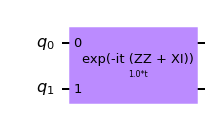

In [ ]:
# We now convert this evolution operator into a circuit using Trotter Expansion:
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter', 
                    reps=num_time_slices).convert(evolution_op)
trotterized_op.to_circuit().draw()

In [ ]:
observable_measurement = StateFn(observable).adjoint()

In [ ]:
#we need an initial state that is an eigenvalue of the Hamiltonian
eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
initial_state = StateFn(eigenstates[0])
print(initial_state.to_circuit_op())


CircuitStateFn(
     ┌───────────────────────────────────────────┐
q_0: ┤0                                          ├
     │  State Preparation(-0.38268,0,0,-0.92388) │
q_1: ┤1                                          ├
     └───────────────────────────────────────────┘
)


In [ ]:
# we now combine circuits using the operator flow according to the following equation:
evo_and_measure = observable_measurement @ evolution_op @ initial_state
print(evo_and_measure)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ
  + 1.0 * XI),
  e^(-i*1.0*t * (
    1.0 * ZZ
    + 1.0 * XI
  )),
  VectorStateFn(Statevector([-0.38268343+0.j, -0.        +0.j,  0.        +0.j,
               -0.92387953+0.j],
              dims=(2, 2)))
])


In [ ]:
# convert our hamiltonian using the PauliTrotter evolution:
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter', 
                    reps=num_time_slices).convert(evo_and_measure)
print(trotterized_op)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ
  + 1.0 * XI),
       ┌────────────────────────────┐
  q_0: ┤0                           ├
       │  exp(-it (ZZ + XI))(1.0*t) │
  q_1: ┤1                           ├
       └────────────────────────────┘,
  VectorStateFn(Statevector([-0.38268343+0.j, -0.        +0.j,  0.        +0.j,
               -0.92387953+0.j],
              dims=(2, 2)))
])


In [ ]:
#Next step is to convert our circuit to suitable basis in order to measure \
#in a real quantum computer, this is done by using PauliExpectation().
#it yields the expectation values as follows
diagonalized_meas_op = PauliExpectation().convert(trotterized_op)
print(diagonalized_meas_op)

SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
         ┌────────────────────────────┐
    q_0: ┤0                           ├
         │  exp(-it (ZZ + XI))(1.0*t) │
    q_1: ┤1                           ├
         └────────────────────────────┘,
    VectorStateFn(Statevector([-0.38268343+0.j, -0.        +0.j,  0.        +0.j,
                 -0.92387953+0.j],
                dims=(2, 2)))
  ]),
  ComposedOp([
    OperatorMeasurement(1.0 * ZI),
         ┌────────────────────────────┐     
    q_0: ┤0                           ├─────
         │  exp(-it (ZZ + XI))(1.0*t) │┌───┐
    q_1: ┤1                           ├┤ H ├
         └────────────────────────────┘└───┘,
    VectorStateFn(Statevector([-0.38268343+0.j, -0.        +0.j,  0.        +0.j,
                 -0.92387953+0.j],
                dims=(2, 2)))
  ])
])


In [ ]:
#let's run our hamiltonian simulation on an ideal quantum computer.
evo_time_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.1]
hamiltonian_trotter_expectations = diagonalized_meas_op.bind_parameters({evo_time: evo_time_points})
print(f"Observable at time {evo_time_points}: {np.round(hamiltonian_trotter_expectations.eval(), 3)}")

Observable at time [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.1]: [ 0.98 +0.j  0.921+0.j  0.825+0.j  0.697+0.j  0.54 +0.j  0.362+0.j
  0.17 +0.j -0.029+0.j -0.227+0.j -0.323+0.j -0.589+0.j]


In [ ]:
#the above is nothing but calculation of expectation values at two different time steps
#we need to run several measurements on a quantum computer. this is called sampling
#to do this we sould convert our operator flow program using CircuitSampler and choose a device to run it.
sampler = CircuitSampler(backend=Aer.get_backend("qasm_simulator"))
sampler.quantum_instance.run_config.shots = 1000
sampled_trotter_exp_op = sampler.convert(hamiltonian_trotter_expectations)
sampled_trotter_energies = sampled_trotter_exp_op.eval()
print(f"Energies: {np.round(np.real(sampled_trotter_energies),3)}")


Energies: [ 0.95   0.888  0.816  0.702  0.522  0.39   0.164 -0.132 -0.186 -0.294
 -0.62 ]


In [ ]:
y = np.round(np.real(sampled_trotter_energies),3)

In [ ]:
#Run several measurements at different time to capture dynamics
#this is where I run out of technical know how  and help is needed to make the computer run several measurements,\
#CREATE TABLES AND MAKE PLOTS


Traceback (most recent call last):
  Input In [23] in <cell line: 1>
    plt.plot(evo_time_points, y, 'H', label=f"t={0.5}")
  File /opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py:2757 in plot
    return gca().plot(
  File /opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1632 in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File /opt/conda/lib/python3.8/site-packages/matplotlib/axes/_base.py:312 in __call__
    yield from self._plot_args(this, kwargs)
  File /opt/conda/lib/python3.8/site-packages/matplotlib/axes/_base.py:498 in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

Use %tb to get the full traceback.


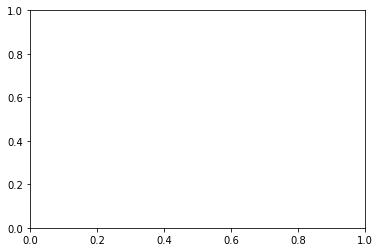

In [ ]:
plt.plot(evo_time_points, y, 'H', label=f"t={0.5}")
#plt.hlines(y=0., xmin=min(n_shots), xmax=max(n_shots) + 1, colors='red')
plt.xlabel("# shots", size=16)
plt.ylabel(r"$ \langle H \rangle $", size=16)
plt.show()